In [1]:
import pandas as pd
# import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d, RegularGridInterpolator
from astropy.io import fits
from astropy.coordinates import SkyCoord
from gammapy.stats import WStatCountsStatistic
from astropy.table import Table
sns.set_palette("colorblind")


In [2]:
hdul_1 = fits.open("fits/65776.mscw.fits")
hdul_2 = fits.open("fits/66735.mscw.fits")
hdul_3 = fits.open("fits/67138.mscw.fits")
hdul_4 = fits.open("fits/67253.mscw.fits")
hdul_5 = fits.open("fits/67272.mscw.fits")
hdul_6 = fits.open("fits/67293.mscw.fits")
hdul_7 = fits.open("fits/69978.mscw.fits")
hdul_8 = fits.open("fits/69979.mscw.fits")

hdul_9 = fits.open("fits/70351.mscw.fits")
hdul_10 = fits.open("fits/70373.mscw.fits")
hdul_11 = fits.open("fits/70458.mscw.fits")
hdul_12 = fits.open("fits/70530.mscw.fits")
hdul_13 = fits.open("fits/74358.mscw.fits")
hdul_14 = fits.open("fits/74829.mscw.fits")
hdul_15 = fits.open("fits/74830.mscw.fits")
hdul_16 = fits.open("fits/74894.mscw.fits")

hdul_17 = fits.open("fits/74915.mscw.fits")
hdul_18 = fits.open("fits/78274.mscw.fits")
hdul_19 = fits.open("fits/79103.mscw.fits")
hdul_20 = fits.open("fits/79158.mscw.fits")
hdul_21 = fits.open("fits/80163.mscw.fits")
hdul_22 = fits.open("fits/80236.mscw.fits")
hdul_23 = fits.open("fits/80532.mscw.fits")
hdul_24 = fits.open("fits/80583.mscw.fits")

hdul_25 = fits.open("fits/80925.mscw.fits")
hdul_26 = fits.open("fits/85245.mscw.fits")
hdul_27 = fits.open("fits/85386.mscw.fits")
hdul_28 = fits.open("fits/87575.mscw.fits")
hdul_29 = fits.open("fits/88132.mscw.fits")
hdul_30 = fits.open("fits/88458.mscw.fits")
hdul_31 = fits.open("fits/88459.mscw.fits")
hdul_32 = fits.open("fits/88712.mscw.fits")

hdul_33 = fits.open("fits/88713.mscw.fits")
hdul_34 = fits.open("fits/88723.mscw.fits")
hdul_35 = fits.open("fits/88749.mscw.fits")

In [3]:
df_1 = Table.read(hdul_1[1]).to_pandas()
df_2 = Table.read(hdul_2[1]).to_pandas()
df_3 = Table.read(hdul_3[1]).to_pandas()
df_4 = Table.read(hdul_4[1]).to_pandas()
df_5 = Table.read(hdul_5[1]).to_pandas()
df_6 = Table.read(hdul_6[1]).to_pandas()
df_7 = Table.read(hdul_7[1]).to_pandas()
df_8 = Table.read(hdul_8[1]).to_pandas()

df_9 = Table.read(hdul_9[1]).to_pandas()
df_10 = Table.read(hdul_10[1]).to_pandas()
df_11 = Table.read(hdul_11[1]).to_pandas()
df_12 = Table.read(hdul_12[1]).to_pandas()
df_13 = Table.read(hdul_13[1]).to_pandas()
df_14 = Table.read(hdul_14[1]).to_pandas()
df_15 = Table.read(hdul_15[1]).to_pandas()
df_16 = Table.read(hdul_16[1]).to_pandas()


In [4]:
df_17 = Table.read(hdul_17[1]).to_pandas()
df_18 = Table.read(hdul_18[1]).to_pandas()
df_19 = Table.read(hdul_19[1]).to_pandas()
df_20 = Table.read(hdul_20[1]).to_pandas()
df_21 = Table.read(hdul_21[1]).to_pandas()
df_22 = Table.read(hdul_22[1]).to_pandas()
df_23 = Table.read(hdul_23[1]).to_pandas()
df_24 = Table.read(hdul_24[1]).to_pandas()

df_25 = Table.read(hdul_25[1]).to_pandas()
df_26 = Table.read(hdul_26[1]).to_pandas()
df_27 = Table.read(hdul_27[1]).to_pandas()
df_28 = Table.read(hdul_28[1]).to_pandas()
df_29 = Table.read(hdul_29[1]).to_pandas()
df_30 = Table.read(hdul_30[1]).to_pandas()
df_31 = Table.read(hdul_31[1]).to_pandas()
df_32 = Table.read(hdul_32[1]).to_pandas()

df_33 = Table.read(hdul_33[1]).to_pandas()
df_34 = Table.read(hdul_34[1]).to_pandas()
df_35 = Table.read(hdul_35[1]).to_pandas()

In [5]:
class Observation():
    
    def __init__(self, df):
        self.data = df
        # for working between sky and camera coordinates
        self.ra_inter = interp1d(df["RA"], df["Xoff_derot"])
        self.dec_inter = interp1d(df["DEC"], df["Yoff_derot"])
        
        # Some details on cuts
        self.theta_cut = 0.089
        self.exclude_radius = 0.3
        self.nregions = 10
        
        # Exclusions Regions
        self.exclude_x = []
        self.exclude_y = []

    def exclude_regions(self, regions):
        self.exclude_x = []
        self.exclude_y = []
        
        for reg in regions:
            self.exclude_x.append(self.ra_inter(reg.ra.deg))
            self.exclude_y.append(self.dec_inter(reg.dec.deg))
            
        self.exclude_x = np.array(self.exclude_x)
        self.exclude_y = np.array(self.exclude_y)
            
            
    def set_coords(self, ra_binning, dec_binning):
        self.ra = ra_binning
        self.dec = dec_binning
        
        self.ra_width = self.ra[1:] - self.ra[:-1]
        self.ra_center = self.ra[:-1] + 0.5 * self.ra_width
        self.dec_width = self.dec[1:] - self.dec[:-1]
        self.dec_center = self.dec[:-1] + 0.5 * self.dec_width
        
                
        self.on_map = np.zeros([
            len(self.ra_center),
            len(self.dec_center)
        ])
        
                
        self.off_map = np.zeros([
            len(self.ra_center),
            len(self.dec_center)
        ])
        
                
        self.alpha_map = np.zeros([
            len(self.ra_center),
            len(self.dec_center)
        ])
        
        self.sigma_map = np.zeros([
            len(self.ra_center),
            len(self.dec_center)
        ])
        
        
    
    def get_signficance_at_region(self, region):
        
        locX = self.ra_inter(region.ra.deg)
        locY = self.dec_inter(region.dec.deg)
        return self.get_signficance_at_pixel(locX, locY)
        
        
    def get_signficance_at_pixel(self, locX, locY):
        delta_angle = 360 / (self.nregions + 1)
        angles = np.rad2deg(np.arctan2( locY, locX,)) + (np.arange(1,self.nregions+1))* delta_angle

        x_off = np.cos(np.deg2rad(angles)) * (np.sqrt(locX**2 + locY**2))
        y_off = np.sin(np.deg2rad(angles)) * (np.sqrt(locX**2 + locY**2))
        
        on_mask = np.sqrt((self.data["Xoff_derot"] - locX)**2 + (self.data["Yoff_derot"] - locY)**2) < self.theta_cut

        
        off_mask = np.zeros(len(self.data), dtype=bool)
        alpha = 0
        for x, y in zip(x_off, y_off):

            ex_test = np.sqrt((self.exclude_x - x)**2 + (self.exclude_y - y)**2) < self.exclude_radius
            if np.any(ex_test):
                continue

            # Applying an "or" to get the total mask
            off_mask_tmp = np.sqrt((self.data["Xoff_derot"] - x)**2 + (self.data["Yoff_derot"] - y)**2) < self.theta_cut 
            off_mask += off_mask_tmp
            alpha += 1

        on_counts = len(self.data[on_mask])
        off_counts = len(self.data[off_mask])
        excess_counts = on_counts - off_counts / alpha
        sigma = WStatCountsStatistic(
                                on_counts,
                                off_counts,
                                1/alpha,
                            ).sqrt_ts

        return on_counts, off_counts, excess_counts, alpha, sigma
        

    def calculate_maps(self):
        
        for i in range(self.on_map.shape[0]):
            for j in range(self.on_map.shape[1]):
                
                # Get the pixel location
                locX = self.ra_inter(self.ra_center[i])
                locY = self.dec_inter(self.dec_center[j])

                # Exclude the inner most region of the camera
                if np.sqrt(locX**2 + locY**2) < 0.15:
                    continue
                    
                # Generate off regions
                delta_angle = 360 / (self.nregions + 1)
                angles = np.rad2deg(np.arctan2( locY, locX,)) + (np.arange(1,self.nregions+1))* delta_angle
                
                x_off = np.cos(np.deg2rad(angles)) * (np.sqrt(locX**2 + locY**2))
                y_off = np.sin(np.deg2rad(angles)) * (np.sqrt(locX**2 + locY**2))

                on_mask = np.sqrt((self.data["Xoff_derot"] - locX)**2 + (self.data["Yoff_derot"] - locY)**2) < self.theta_cut
                
                off_mask = np.zeros(len(self.data), dtype=bool)
                alpha = 0
                for x, y in zip(x_off, y_off):
                    
                    ex_test = np.sqrt((self.exclude_x - x)**2 + (self.exclude_y - y)**2) < self.exclude_radius
                    if np.any(ex_test):
                        continue
                    
                    # Applying an "or" to get the total mask
                    off_mask_tmp = np.sqrt((self.data["Xoff_derot"] - x)**2 + (self.data["Yoff_derot"] - y)**2) < self.theta_cut 
                    off_mask += off_mask_tmp
                    alpha += 1
                
                self.on_map[i,j] = len(self.data[on_mask])
                self.off_map[i,j] = len(self.data[off_mask])
                self.alpha_map[i,j] = 1./alpha
                
                self.sigma_map[i,j] = WStatCountsStatistic(
                                self.on_map[i,j],
                                self.off_map[i,j],
                                self.alpha_map[i,j],
                            ).sqrt_ts


In [6]:
class SkyMaps():
    
    def __init__(self, observations):
        
        self.observations = []
        for obs in observations:
            self.observations.append(Observation(obs))
            
    def exclude_regions(self, regions):
        for obs in self.observations:
            obs.exclude_regions(regions)
            
    def set_coords(self, ra_binning, dec_binning):
        for obs in self.observations:
            obs.set_coords(ra_binning, dec_binning)
            
            
    def get_signficance_at_region(self, region):
        on_counts = np.zeros(len(self.observations) + 1)
        off_counts = np.zeros(len(self.observations) + 1)
        excess_counts = np.zeros(len(self.observations) + 1)
        alpha = np.zeros(len(self.observations) + 1)
        sigma = np.zeros(len(self.observations) + 1)
        
        for i, obs in enumerate( self.observations):
            on_counts[i], off_counts[i], excess_counts[i], alpha[i], sigma[i]  = obs.get_signficance_at_region(region)
        
        on_counts[-1] = np.sum(on_counts[:-1])
        off_counts[-1] = np.sum(off_counts[:-1])
        excess_counts[-1] = np.sum(excess_counts[:-1])
        alpha[-1] = np.mean(alpha[:-1])
        sigma[-1] = WStatCountsStatistic(
                                on_counts[-1],
                                off_counts[-1],
                                1/alpha[-1],
                            ).sqrt_ts

        
        return on_counts, off_counts, excess_counts, alpha, sigma        
    
    
    
    def calculate_maps(self):
        
        for i, obs in enumerate(self.observations):
            obs.calculate_maps()
            if i == 0:
                self.on_map = obs.on_map
                self.off_map = obs.off_map
                self.alpha_map = np.zeros(obs.off_map.shape)
                self.excess_map = np.zeros(obs.off_map.shape)
                alpha_mask = (np.isfinite(obs.alpha_map)) & (obs.alpha_map > 0)

                self.alpha_map[alpha_mask] = 1./obs.alpha_map[alpha_mask]
                self.excess_map[alpha_mask] = obs.on_map[alpha_mask] + self.alpha_map[alpha_mask] * self.off_map[alpha_mask]
            
            else:
                alpha_mask = (np.isfinite(obs.alpha_map)) & (obs.alpha_map > 0)
                self.on_map[alpha_mask] += obs.on_map[alpha_mask]
                self.off_map[alpha_mask] += obs.off_map[alpha_mask]
                self.excess_map[alpha_mask] += obs.on_map[alpha_mask] + obs.alpha_map[alpha_mask] * obs.off_map[alpha_mask]
                self.alpha_map[alpha_mask] += 1./obs.alpha_map[alpha_mask]
                
        # Get the average alpha_map
        self.alpha_map /= len(self.observations)
        self.alpha_map = 1./ self.alpha_map
        self.sig_map = np.zeros(self.alpha_map.shape)
        
        # Get the significance
        for i in range(self.on_map.shape[0]):
            for j in range(self.on_map.shape[1]):
                self.sig_map[i,j] = WStatCountsStatistic(
                                self.on_map[i,j],
                                self.off_map[i,j],
                                self.alpha_map[i,j],
                            ).sqrt_ts
                
                

# Applying Standard Cuts to Crab Data

In [7]:
dfs = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12,
       df_13,df_14,df_15,df_16,df_17,df_18,df_19,df_20,df_21,df_22,df_23,
       df_24,df_25,df_26,df_27,df_28,df_29,df_30,
       df_31,df_32,df_33,df_34,df_35]

In [9]:
for i in range(0,35):
    dfs[i] = dfs[i][dfs[i]['SizeSecondMax'] > 400]
    dfs[i] = dfs[i][np.logical_and(dfs[i]['EmissionHeight'] > 6., dfs[i]['EmissionHeight'] < 1e10)]
    dfs[i] = dfs[i][np.logical_and(dfs[i]['MSCW'] > -1.2, dfs[i]['MSCW'] < 0.3)]
    dfs[i] = dfs[i][np.logical_and(dfs[i]['MSCL'] > -1.2, dfs[i]['MSCL'] < 0.5)]
    

In [29]:
crab = SkyCoord.from_name("Crab")

In [30]:
myObs = Observation(dfs[0])
crab = SkyCoord.from_name("Crab")
myObs.exclude_regions([crab])

ra_bins = np.arange(crab.ra.deg - 1.5, crab.ra.deg + 1.5, 0.04)
dec_bins = np.arange(crab.dec.deg - 1.5, crab.dec.deg + 1.5, 0.04)

myObs.set_coords(ra_bins, dec_bins)

In [31]:
myObs.get_signficance_at_region(crab)

(324, 271, 290.125, 8, 25.836448246431978)

In [32]:
on, off, excess, alpha, sigma = myObs.get_signficance_at_region(crab)

In [33]:
myObs.calculate_maps()

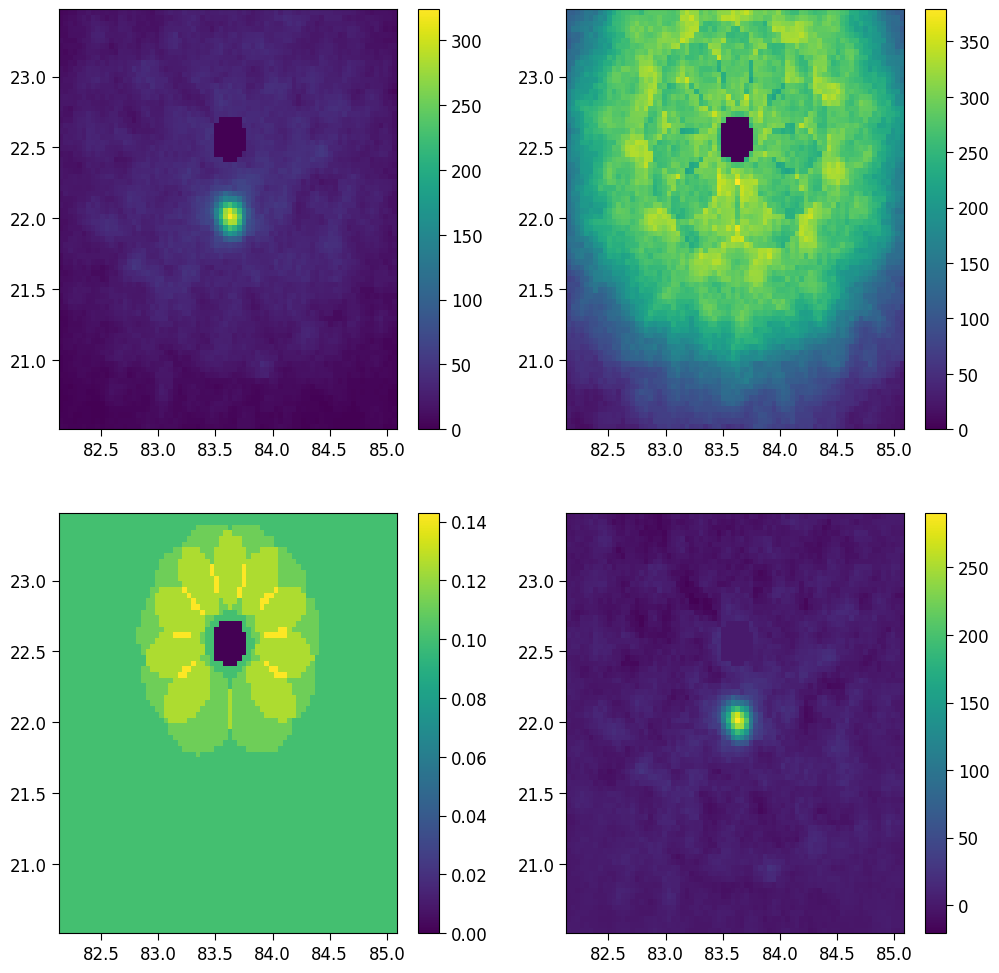

In [34]:
fig, axs = plt.subplots(2,2, figsize = (12,12))

p00= axs[0,0].pcolormesh(myObs.ra, myObs.dec, myObs.on_map)
plt.colorbar(p00, ax=axs[0,0])
p01= axs[0,1].pcolormesh(myObs.ra, myObs.dec, myObs.off_map)
plt.colorbar(p01, ax=axs[0,1])
p10= axs[1,0].pcolormesh(myObs.ra, myObs.dec, myObs.alpha_map)
plt.colorbar(p10, ax=axs[1,0])
p11= axs[1,1].pcolormesh(myObs.ra, myObs.dec, myObs.on_map - myObs.off_map * myObs.alpha_map)
plt.colorbar(p11, ax=axs[1,1])
plt.savefig('SC_runmaps')

Significance of Crab obtained from SC on one run: 25.84


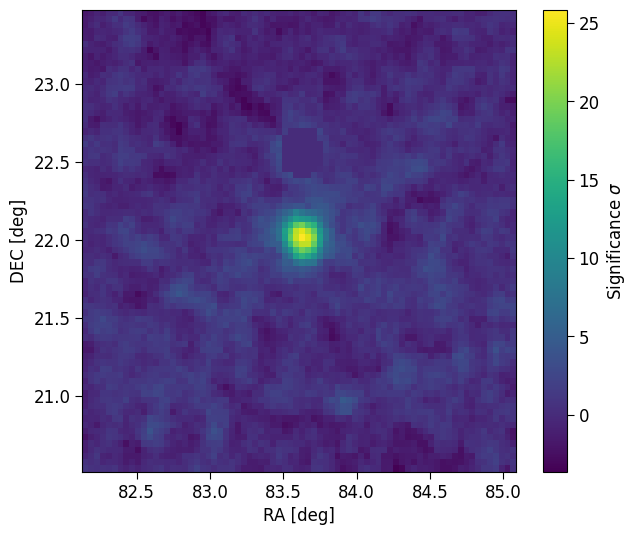

In [36]:
fig, axs = plt.subplots(figsize = (7,6))

p11 = axs.pcolormesh(ra_bins, dec_bins, myObs.sigma_map)
plt.colorbar(p11, ax=axs, label='Significance $\sigma$')
plt.ylabel('DEC [deg]')
plt.xlabel('RA [deg]')
plt.savefig('SC_runsig')
# max_index= np.unravel_index(np.argmax(myMaps.sig_map), myMaps.sig_map.shape)
# max_value = myMaps.sig_map[max_index]

print("Significance of Crab obtained from SC on one run:", round(sigma,2))

In [19]:
myMaps = SkyMaps([df for df in dfs])

myMaps.exclude_regions([crab])

ra_bins = np.arange(crab.ra.deg - 1.5, crab.ra.deg + 1.5, 0.05)
dec_bins = np.arange(crab.dec.deg - 1.5, crab.dec.deg + 1.5, 0.05)

myMaps.set_coords(ra_bins, dec_bins)

In [24]:
on, off, excess, alpha, sigma = myMaps.get_signficance_at_region(crab)
sigma

array([ 25.83644825,  23.78587769,  23.20551877,  22.51337743,
        25.05389232,  23.55756364,  20.67583217,  23.19189306,
        21.87140856,  20.97079921,  22.62101045,  21.13538076,
        21.51231483,  21.66741198,  21.58989971,  22.63212052,
        21.07506224,  22.21738348,  21.1961671 ,  14.56039088,
        20.83043352,  22.6106976 ,  21.86302826,  21.69637281,
        18.94108293,  20.59928282,  20.04263541,  18.15512565,
        21.84768597,  18.47950624,  19.05135781,  18.67907981,
        20.28859259,  20.78901227,  22.39783373, 127.01585085])

In [21]:
myMaps.calculate_maps()

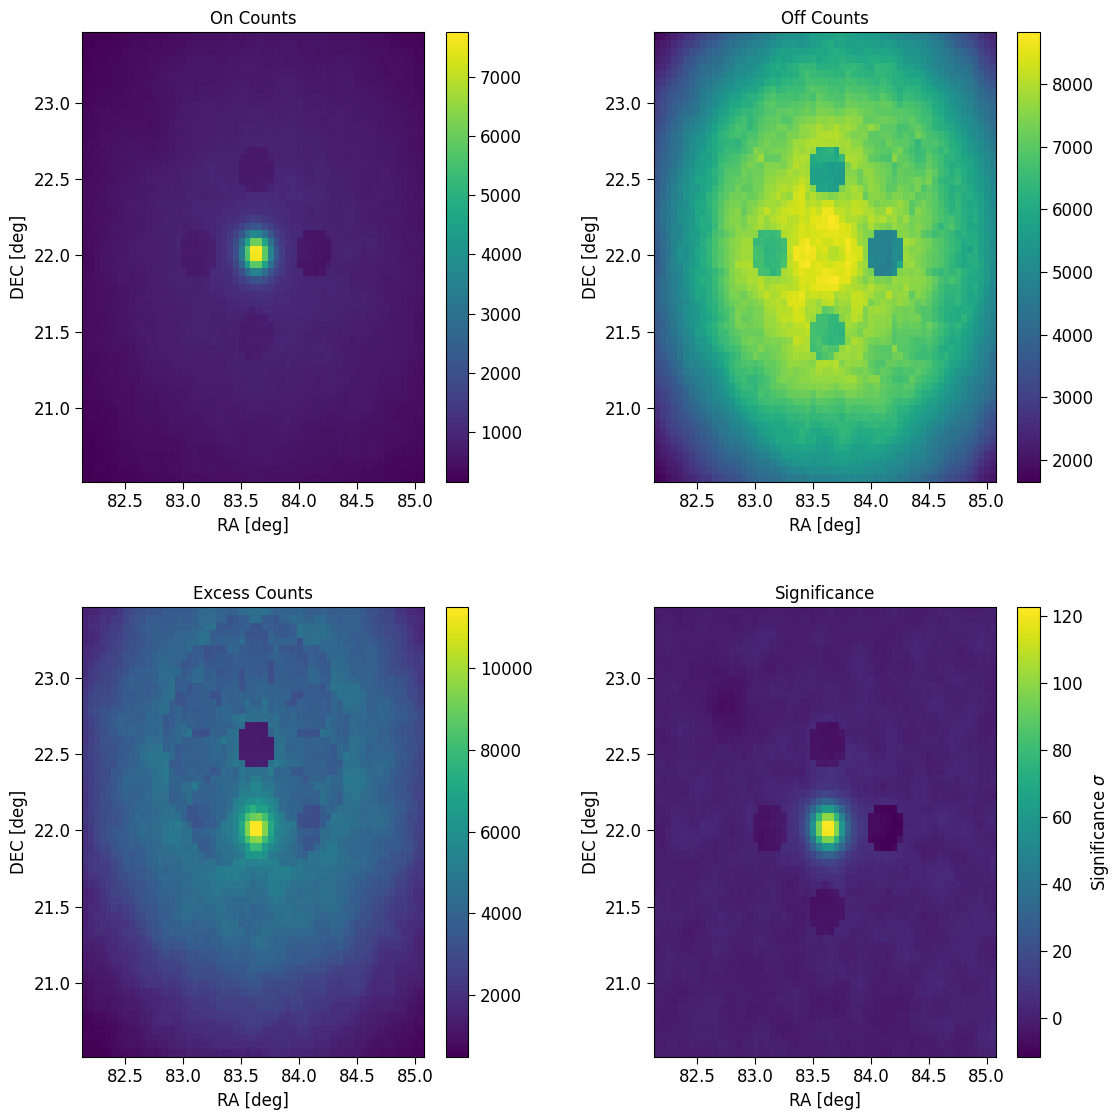

In [27]:
fig, axs = plt.subplots(2,2, figsize = (12,12))

p00 = axs[0,0].pcolormesh(ra_bins, dec_bins, myMaps.on_map)
plt.colorbar(p00, ax=axs[0,0])
axs[0,0].set_title('On Counts')
axs[0,0].set_ylabel('DEC [deg]')
axs[0,0].set_xlabel('RA [deg]')

p01 = axs[0,1].pcolormesh(ra_bins, dec_bins, myMaps.off_map)
plt.colorbar(p01, ax=axs[0,1])
axs[0,1].set_title('Off Counts')
axs[0,1].set_ylabel('DEC [deg]')
axs[0,1].set_xlabel('RA [deg]')

p10 = axs[1,0].pcolormesh(ra_bins, dec_bins, myMaps.excess_map)
plt.colorbar(p10, ax=axs[1,0])
axs[1,0].set_title('Excess Counts')
axs[1,0].set_ylabel('DEC [deg]')
axs[1,0].set_xlabel('RA [deg]')

p11 = axs[1,1].pcolormesh(ra_bins, dec_bins, myMaps.sig_map)
plt.colorbar(p11, ax=axs[1,1], label = 'Significance $\sigma$')
axs[1,1].set_title('Significance')
axs[1,1].set_ylabel('DEC [deg]')
axs[1,1].set_xlabel('RA [deg]')

plt.tight_layout(pad = 3)
plt.savefig('SC_summaps')

Summed significance of Crab obtained from Standard Cuts: 127.02


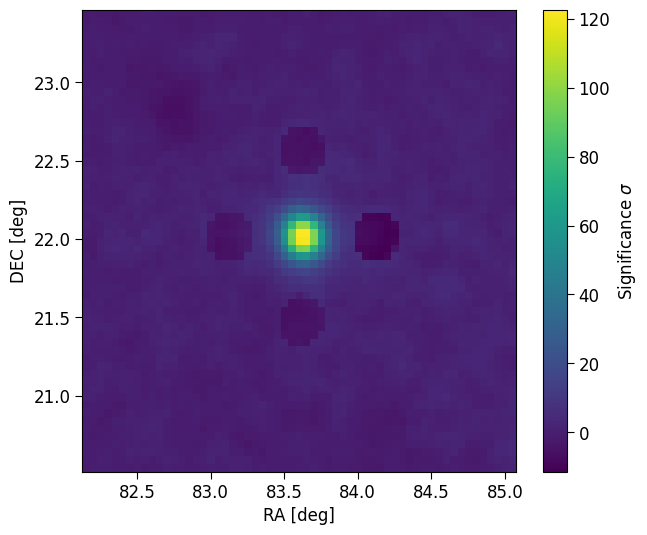

In [28]:
fig, axs = plt.subplots(figsize = (7,6))

p11 = axs.pcolormesh(ra_bins, dec_bins, myMaps.sig_map)
plt.colorbar(p11, ax=axs, label='Significance $\sigma$')
plt.ylabel('DEC [deg]')
plt.xlabel('RA [deg]')
plt.savefig('SC_sumsig')

print("Summed significance of Crab obtained from Standard Cuts:", round(sigma[-1],2))

In [26]:
fontsize = 12
ticklen = 5
params = {
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'xtick.major.size' : ticklen,
    'ytick.major.size' : ticklen,
    'xtick.minor.size' : ticklen/2,
    'ytick.minor.size' : ticklen/2
}
plt.rcParams.update(params)

In [ ]:
# max_index= np.unravel_index(np.argmax(myMaps.sig_map), myMaps.sig_map.shape)
# max_value = myMaps.sig_map[max_index]